# Preprocessing Workflow for DWI:

This is an example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of anatomical (T1) images with FSL's MCFLIRT
2. Motion correction of anatomical (DWI) images using Dipy
3. Coregistration of anatomical(DWI) images to _?_ (according to FSL's FEAT pipeline)
4. Registration using a New Interface of DWI images using Dipy

In [1]:
# import the main Nipype tools
from nipype import Node, Workflow

In [2]:
#import the interfaces that we want to use for the preprocessing
#from nipype.interfaces.fsl import BET
from nipype.interfaces.fsl import (EddyCorrect, BET, FAST, Threshold, FLIRT)
import nipype.interfaces.dipy as dipy
from preprocessing.interfaces.N4Bias import N4Bias

In [3]:
import os
from os.path import abspath

from nilearn.plotting import plot_anat
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
input_t1 = abspath("/home/jscanass/brain/data/candela/Benhammou_S/t1_f20161205_133603t1mprtra320160cs018a1001.nii.gz")
input_dwi = abspath("/home/jscanass/brain/data/candela/Benhammou_S/dwi_4Df20161205_133603DTI64dirStrictStricteISOs012a001_01.nii.gz")
input_bval = abspath("/home/jscanass/brain/data/candela/Benhammou_S/20161205_133603DTI64dirStrictStricteISOs012a001.bval")
input_bvec = abspath('/home/jscanass/brain/data/candela/Benhammou_S/20161205_133603DTI64dirStrictStricteISOs012a001.bval')

/home/jscanass/brain/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


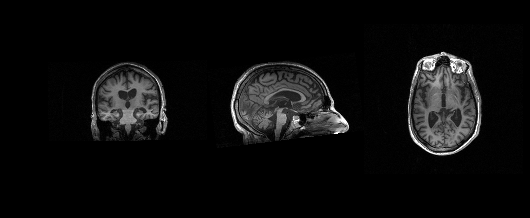

In [5]:
plot_anat(input_t1, 
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);

In [6]:
#plot dwi (b0)
#http://nipy.org/niwidgets/index.html
#https://nipy.org/nibabel/coordinate_systems.html

In [7]:
"""
Eddy Correction
WARNING: Deprecated in FSL. Please use nipype.interfaces.fsl.epi.Eddy instead
https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.fsl/epi.html
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup
"""
eddyc = Node(EddyCorrect(ref_num=0), name = 'eddy_current')

"""
# Denoise (NL Means) and Reslicing
References: 
https://nipype.readthedocs.io/en/0.12.0/interfaces/generated/nipype.interfaces.dipy.preprocess.html
https://nipy.org/dipy/examples_built/denoise_nlmeans.html#example-denoise-nlmeans
"""

denoise = Node(dipy.Denoise(), name='denoise_nlmeans')
reslice = Node(dipy.Resample(), name='reslice')

"""
Bet - Skullstrip anatomical and funtional images 

Median Otsu: http://nipy.org/dipy/examples_built/brain_extraction_dwi.html
https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.slicer/legacy.segmentation.html#otsuthresholdsegmentation
https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.slicer/legacy.filtering.html#otsuthresholdimagefilter
"""

bet = Node(BET(frac=0.5,mask=True), name='bet') #robust=True ?



190427-12:58:31,898 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
190427-12:58:31,903 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


In [8]:
# create the preprocessing workflow
preproc_dwi = Workflow(name='preproc_dwi', base_dir='/output/')

In [9]:
preproc_dwi.connect([(eddyc, denoise, [("eddy_corrected", "in_file")])])
preproc_dwi.connect([(denoise, reslice, [("out_file", "in_file")])])
preproc_dwi.connect([(reslice, bet, [("out_file", "in_file")])])

In [10]:
preproc_dwi.write_graph("data/candela/Benhammou_S/workflow_graph.dot")

190427-12:58:33,63 nipype.workflow INFO:
	 Generated workflow graph: data/candela/Benhammou_S/workflow_graph.png (graph2use=hierarchical, simple_form=True).


'data/candela/Benhammou_S/workflow_graph.png'

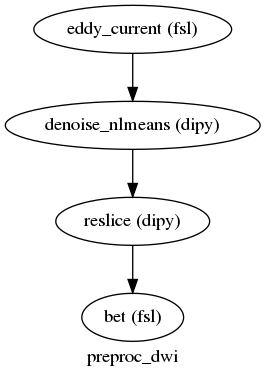

In [11]:
from IPython.display import Image
Image(filename="data/candela/Benhammou_S/workflow_graph.png")

In [12]:
preproc_dwi.write_graph("data/candela/Benhammou_S/workflow_grap_orig.dot",graph2use='orig')

190427-12:58:33,588 nipype.workflow INFO:
	 Generated workflow graph: /home/jscanass/brain/dwi_processing/data/candela/Benhammou_S/workflow_grap_orig.png (graph2use=orig, simple_form=True).


'/home/jscanass/brain/dwi_processing/data/candela/Benhammou_S/workflow_grap_orig.png'

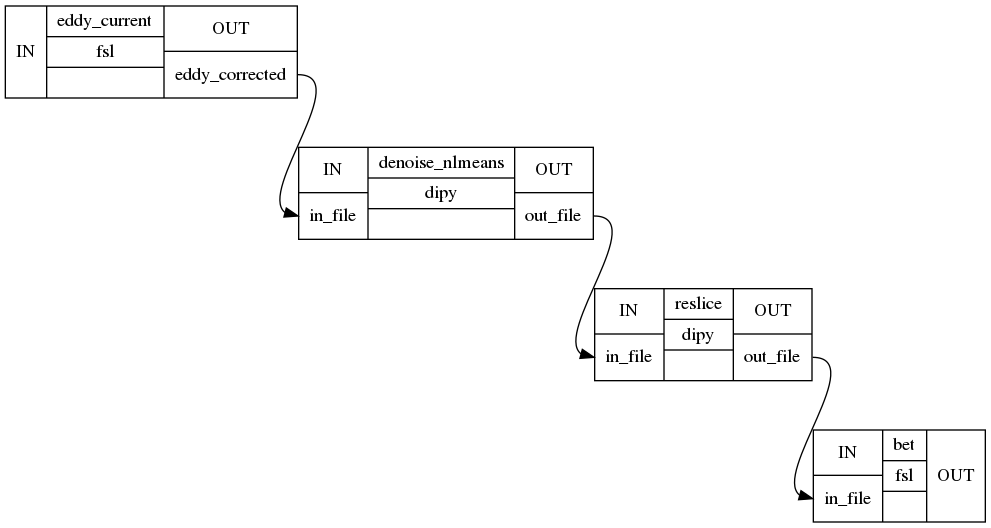

In [13]:
Image(filename="data/candela/Benhammou_S/workflow_grap_orig_detailed.png")

## Coregistration:

In [14]:
# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI'), name="segmentation")

# Interface made by jrudas --> understand and make documentation
n4bias = Node(N4Bias(out_file='t1_n4bias.nii.gz'), name='n4bias')

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="wm_mask_threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'), name="linear_warp_estimation")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6, cost='bbr'),
                        name="nonlinear_warp_estimation")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline'), #,apply_isoxfm=iso_size)
                 name="registration_fmri")

190427-12:58:33,890 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
190427-12:58:33,894 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
190427-12:58:33,897 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
190427-12:58:33,900 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
190427-12:58:33,903 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


In [15]:
# Create a coregistration workflow
coregwf = Workflow(name='coregwf',base_dir='/output/')

In [16]:
coregwf.connect([(bet, n4bias, [('out_file', 'in_file')]),
                 (n4bias, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]), #get_latest?
                 (n4bias, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (n4bias, applywarp, [('out_file', 'reference')]),
                 ])

In [17]:
coregwf.write_graph("data/candela/Benhammou_S/workflow_graph.dot")

190427-12:58:34,620 nipype.workflow INFO:
	 Generated workflow graph: data/candela/Benhammou_S/workflow_graph.png (graph2use=hierarchical, simple_form=True).


'data/candela/Benhammou_S/workflow_graph.png'

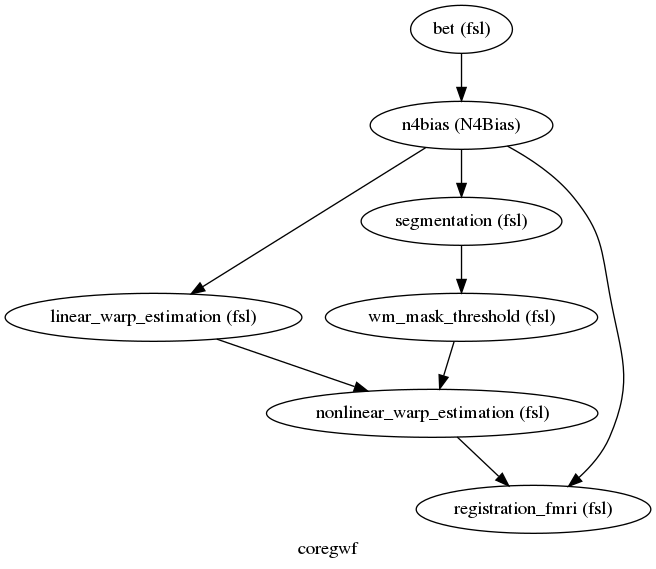

In [18]:
from IPython.display import Image
Image(filename="data/candela/Benhammou_S/workflow_graph.png")

In [19]:
coregwf.write_graph("data/candela/Benhammou_S/workflow_grap_orig.dot2",graph2use='orig')

190427-12:58:35,627 nipype.workflow INFO:
	 Generated workflow graph: /home/jscanass/brain/dwi_processing/data/candela/Benhammou_S/workflow_grap_orig.png (graph2use=orig, simple_form=True).


'/home/jscanass/brain/dwi_processing/data/candela/Benhammou_S/workflow_grap_orig.png'

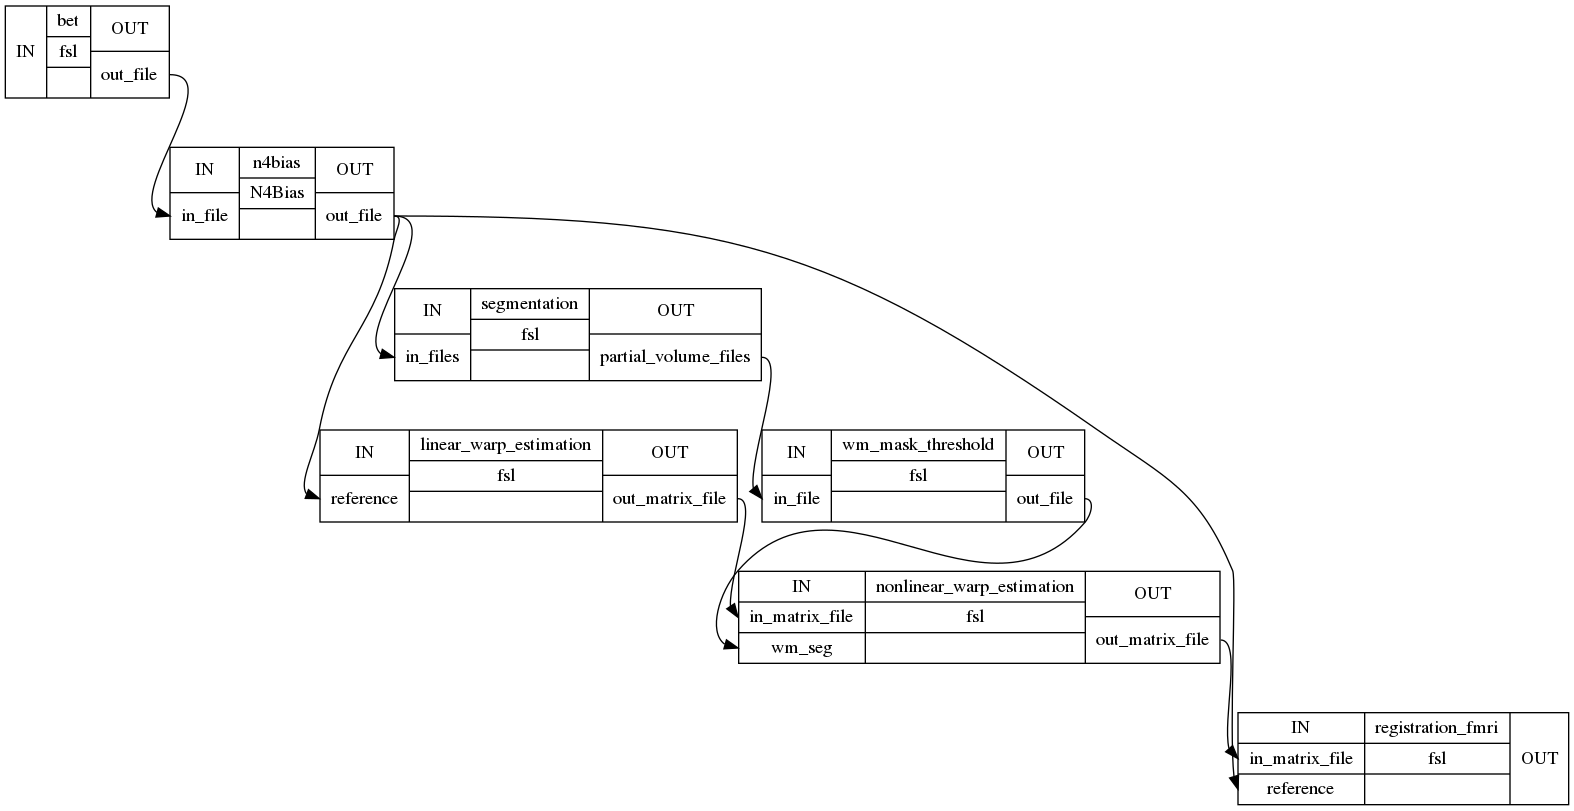

In [20]:
Image(filename="data/candela/Benhammou_S/workflow_grap_orig_detailed.png")

In [21]:
preproc_t1 = Workflow(name='preporct1',base_dir='/output/')
preproc_t1.connect([(bet, n4bias, [("out_file", "in_file")])])

In [22]:
from preprocessing.interfaces.Registration import Registration
registration = Node(Registration(out_file='t1_reg_node.nii.gz'), name='registration')
Registration.help()

Inputs::

        [Mandatory]
        in_file: (an existing file name)
                The input 4D diffusion-weighted image file
        static: (an existing file name)
                T1 or B0 static reference file
        out_file: (a file name)
                output file

Outputs::

        out_file: (a file name)



In [23]:
preproc_wf = Workflow(name="preprocessing", base_dir="/output/")
preproc_wf.connect([(preproc_t1, coregwf, [("out_file", "in_file")]),
             (coregwf, preproc_dwi, [("out_file", "in_file")]),
             ])

Exception: Some connections were not found
Module coregwf has no input called in_file

Module preporct1 has no output called out_file

Module preproc_dwi has no input called in_file

Module coregwf has no output called out_file


In [ ]:
"""
DIPY: https://github.com/nipy/nipype/pull/2830
        
https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.dipy.html
https://nipype.readthedocs.io/en/latest/users/examples/dmri_fsl_dti.html
https://nipype.readthedocs.io/en/latest/users/examples/dmri_preprocessing.html
"""